In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
from scipy.spatial import HalfspaceIntersection

from voting import matrix_op_robust_voting

import sys
sys.path.append("../")
from convex_adversarial import robust_loss, robust_loss_parallel
from trainer import robust_loss_cascade, sampler_robust_cascade

%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")

import numpy as np

from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from pandas import DataFrame

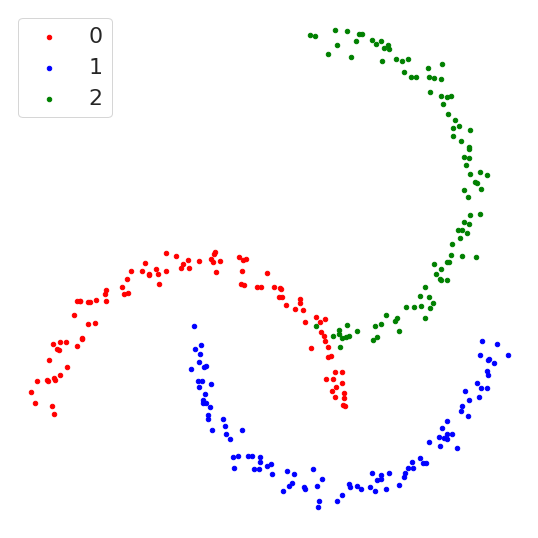

In [2]:
# generate 2d classification dataset
X_train, y_train = make_moons(n_samples=200, noise=0.05)
# X_train_out, y_train_out = make_moons(n_samples=300, noise=0.1)
# scatter plot, dots colored by class value
X_train2, y_train2 = make_moons(n_samples=200, noise=0.05)

transformation_matrix = np.array(
    [[ 0, -1],
 [ 1,0]]
)

X_train2 = X_train2 @ transformation_matrix

X_train2[:, 1] += 1.5
X_train2[:, 0] += 0.9

half_y_train2_idx = y_train2 == 0
y_train2 = y_train2[half_y_train2_idx]
X_train2 = X_train2[half_y_train2_idx]

y_train2 += 2

X_train = np.concatenate([X_train, X_train2])
y_train = np.concatenate([y_train, y_train2])

X_train -= np.min(X_train, axis=0, keepdims=True)
X_train /= np.max(X_train, axis=0, keepdims=True)

df = DataFrame(dict(x=X_train[:,0], y=X_train[:,1], label=y_train))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots(figsize=(8,8))
ax.axis("off")
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key], fontsize=26)
plt.tight_layout()
plt.savefig("data.pdf", dpi=300)
plt.show()

In [3]:
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()

In [4]:
net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,256),
    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256,3)
)

opt = optim.Adam(net.parameters(), lr=1e-3)

net = net


for i in range(500):
    out = net(Variable(X_train))
    l = nn.CrossEntropyLoss()(out, Variable(y_train.long()))
    err = (out.max(1)[1].detach().cpu().data != y_train).float().mean()
    if i % 100 == 0:
        print(l.data, err)
    opt.zero_grad()
    (l).backward()
    opt.step()
print(err)

tensor(1.1022) tensor(0.8733)
tensor(0.1015) tensor(0.0300)
tensor(0.0275) tensor(0.0067)
tensor(0.0213) tensor(0.0067)
tensor(0.0201) tensor(0.0067)
tensor(0.0067)


In [5]:
N = 200

In [6]:
def draw_boundary_standard_models(net, N=200, save_as=None):

    N = 200
    XX, YY = np.meshgrid(np.linspace(0, 1, N), np.linspace(-0.2, 1, N))
    X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
    y0 = net(X0)
    Y0 = torch.argmax(y0, dim=1).long().resize(N,N)


    fig, ax = plt.subplots(figsize=(8,8))
    ax.contourf(XX,YY,Y0, colors=[[1, 0, 0, 0.5], [0, 0, 1, 0.5] , [0., 1, 0, 0.5]], levels=4)
    ax.scatter(X_train[y_train==0][:,0], X_train[y_train==0][:,1], c=[1, 0, 0, 1.0], s=50, edgecolors='k')
    ax.scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1], c=[0, 0, 1, 1.0], s=50, edgecolors='k')
    ax.scatter(X_train[y_train==2][:,0], X_train[y_train==2][:,1], c=[0, 1, 0, 1.0], s=50, edgecolors='k')
    ax.axis("off")
    if save_as is not None:
        plt.tight_layout()
        plt.savefig(f"{save_as}.pdf", dpi=300)
    plt.show()

/opt/conda/lib/python3.8/site-packages/torch/tensor.py:454: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argume

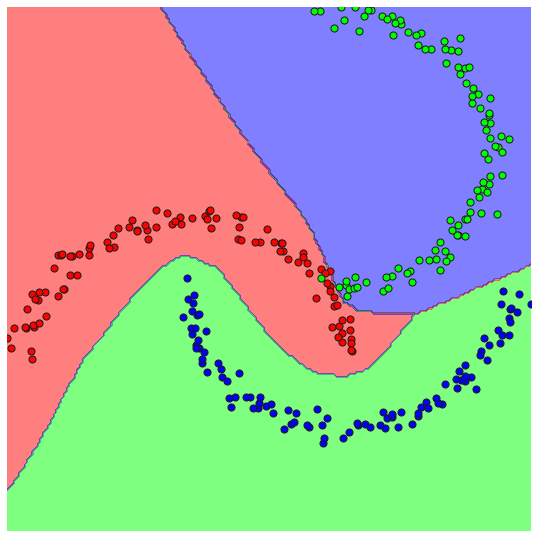

In [7]:
draw_boundary_standard_models(net, N=200, save_as='non-robust-model')

In [8]:
X, y = X_train, y_train.long()
epsilon = 0.05
N = 300

In [9]:
def get_robust_model(features, labels, epochs=100, lr=1e-3):
#     torch.manual_seed(seed)
    f =  nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,256),
    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256,3)
)
    
    data = []
    opt = optim.Adam(f.parameters(), lr=lr)
    for i in range(epochs):
        robust_ce, robust_err = robust_loss(f, epsilon, features, labels)
        out = f(features)
        l2 = nn.CrossEntropyLoss()(out, Variable(labels))
        err = (out.max(1)[1].data != labels).float().mean()
        data.append([l2.data, robust_ce.data, err, robust_err])
        opt.zero_grad()
        (robust_ce).backward()
        opt.step()
    
    print(f"CRA: {1-robust_err}")
        
    return f

def get_robust_predictions(XX, YY, m):
    X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
    y0 = m(X0)
    ZZ = (y0[:,0] - y0[:,1]).resize(N,N).data.numpy()
    
    Y0 = torch.argmax(y0, dim=1).long()
    
    batch_size = 512
    certificates = []
    for i in range(0, X0.shape[0], batch_size):
        x1 = X0[i:i+batch_size]
        y1 = Y0[i:i+batch_size]
        _, _, c = robust_loss(m, epsilon, x1, y1, return_certificate=True)
        certificates.append(c)

    Y0 = Y0.resize(N, N)
    certificates = torch.cat(certificates, dim=0)

    return Y0, certificates.resize(N,N).data



get_model = lambda : nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,256),
    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256,3)
)

# def train_robust_model(f, dataloader, epochs=100):
    
#     loss_fn = nn.CrossEntropyLoss()
#     opt = optim.Adam(f.parameters(), lr=1e-3)
#     for _ in range(epochs):
#         for features, labels in dataloader:
#             features = features
#             labels = labels
#             robust_ce, robust_err = robust_loss(f, epsilon, features, labels)
#             out = f(features)
#             l2 = loss_fn(out, Variable(labels))
#             err = (out.max(1)[1].data != labels).float().mean()
#             data.append([l2.data, robust_ce.data, err, robust_err])
#             opt.zero_grad()
#             (robust_ce).backward()
#             opt.step()
    
# #     print(l2.data, robust_ce.data, robust_err)
    
# #     print(f"CRA: {1-robust_err}")
        
#     return f

# def cascad_training(epochs=50, max_models=5):

#     sampler_indices = []
#     model = []
    
#     dataset = torch.utils.data.TensorDataset(X, y)
#     trainloader = torch.utils.data.DataLoader(dataset, batch_size=500)
    
#     for _ in range(max_models): 
#         # reduce dataset to just uncertified examples

#         number_points = 0
#         for x1, _ in trainloader:
#             number_points += x1.shape[0]
            
#         print(number_points)
        
#         model.append(train_robust_model(get_model(), trainloader, epochs=100))
        
#         print("Reducing dataset...")
#         trainloader = sampler_robust_cascade(trainloader, model, epsilon,
#                                               128, bounded_input=True)
#         if trainloader is None: 
#             print('No more examples, terminating')
#             break
#         sampler_indices.append(trainloader.sampler.indices)
            
#     return model

In [10]:
X_train_left = X_train.clone()
X_train_left[:, 1] -= 0.1


X_train_right = X_train.clone()
X_train_right[:, 0] += 0.1

m1 = get_robust_model(X_train, y_train.long(), epochs=500, lr=1e-3)
m2 = get_robust_model(X_train_left, y_train.long(), epochs=500, lr=1e-3)
m3 = get_robust_model(X_train_right, y_train.long(), epochs=500, lr=1e-3)

../convex_adversarial/dual_layers.py:189: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:983.)
  self.I_ind = I.view(-1,n).nonzero()


CRA: 0.9066666666666666
CRA: 0.92
CRA: 0.91


In [11]:
XX, YY = np.meshgrid(np.linspace(0, 1, N), np.linspace(-0.2, 1.2, N))

In [85]:
def color_the_boundary(Z_original, C):
    
    if isinstance(Z_original, np.ndarray):
        Z = Z_original.copy()
    elif isinstance(Z_original, torch.Tensor):
        Z = Z_original.clone()
    
    CLASS_ONE_ROBUST = 0
    CLASS_ONE_NONROBUST = 3
    CLASS_TWO_ROBUST = 1
    CLASS_TWO_NONROBUST = 4
    CLASS_THREE_ROBUST = 2
    CLASS_THREE_NONROBUST = 5
    
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            if Z[i, j] == 0 and C[i, j] == 1:
                Z[i, j] = CLASS_ONE_ROBUST
            elif Z[i, j] == 0 and C[i, j] == 0:
                Z[i, j] = CLASS_ONE_NONROBUST
            elif Z[i, j] == 1 and C[i, j] == 1:
                Z[i, j] = CLASS_TWO_ROBUST
            elif Z[i, j] == 1 and C[i, j] == 0:
                Z[i, j] = CLASS_TWO_NONROBUST
            elif Z[i, j] == 2 and C[i, j] == 1:
                Z[i, j] = CLASS_THREE_ROBUST
            elif Z[i, j] == 2 and C[i, j] == 0:
                Z[i, j] = CLASS_THREE_NONROBUST
            else:
                raise ValueError
    return Z



In [86]:
use_shaded_color = True

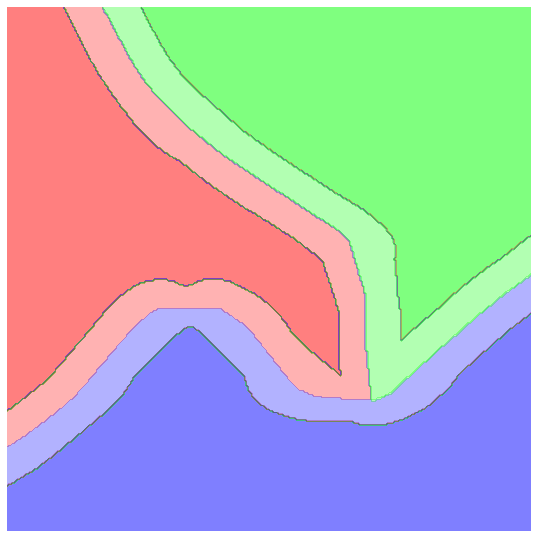

In [87]:
ZZ1_raw, C1 = get_robust_predictions(XX.copy(), YY.copy(), m1)

fig, ax = plt.subplots(figsize=(8,8))

if not use_shaded_color:
    ZZ1 = torch.where(C1 == True, ZZ1_raw, torch.zeros((N, N)).long()+3)
    ax.contourf(XX,YY, ZZ1, colors=[[1, 0, 0, 0.5], 
                                    [0, 0, 1, 0.5], 
                                    [0., 1, 0, 0.5], 
                                    [0., 0, 0, 0.4]], 
                levels=3)
else:
    ZZ1 = color_the_boundary(ZZ1_raw, C1)
    ax.contourf(XX,YY, ZZ1, colors=[[1, 0, 0, 0.5], 
                                    [0, 0, 1, 0.5], 
                                    [0, 1, 0, 0.5], 
                                    [1, 0, 0, 0.3],
                                    [0, 0, 1, 0.3],
                                    [0, 1, 0, 0.3],
                                    [0, 1, 0, 0.3]])


# ax.scatter(X_train[y_train==0][:,0], X_train[y_train==0][:,1], c=[1, 0, 0, 1.0], s=70, edgecolors='k')
# ax.scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1], c=[0, 0, 1, 1.0], s=70, edgecolors='k')
# ax.scatter(X_train[y_train==2][:,0], X_train[y_train==2][:,1], c=[0, 1, 0, 1.0], s=70, edgecolors='k')
ax.axis("off")
ax.axis([0,1,-0.2,1.2])
plt.tight_layout()
plt.savefig("m1.pdf", dpi=300)
plt.show()

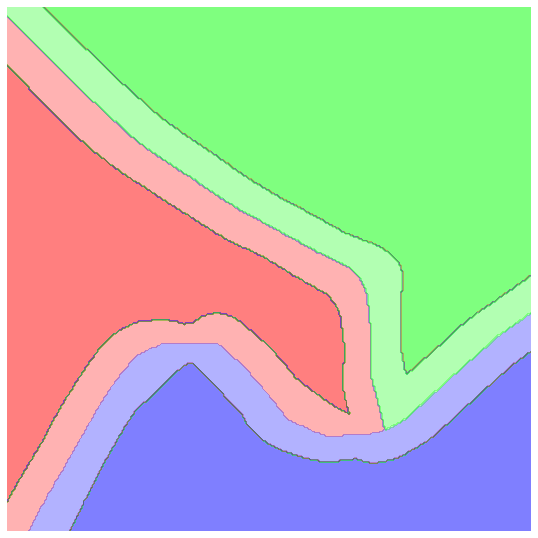

In [88]:
ZZ2_raw, C2 = get_robust_predictions(XX.copy(), YY.copy(), m2)

ZZ2 = torch.where(C2 == True, ZZ2_raw, torch.zeros((N, N)).long()+3)

fig, ax = plt.subplots(figsize=(8,8))

if not use_shaded_color:
    ZZ2 = torch.where(C2 == True, ZZ2_raw, torch.zeros((N, N)).long()+3)
    ax.contourf(XX,YY, ZZ2, colors=[[1, 0, 0, 0.5], 
                                    [0, 0, 1, 0.5], 
                                    [0., 1, 0, 0.5], 
                                    [0., 0, 0, 0.4]], 
                levels=3)
else:
    ZZ2 = color_the_boundary(ZZ2_raw, C2)
    ax.contourf(XX,YY, ZZ2, colors=[[1, 0, 0, 0.5], 
                                    [0, 0, 1, 0.5], 
                                    [0, 1, 0, 0.5], 
                                    [1, 0, 0, 0.3],
                                    [0, 0, 1, 0.3],
                                    [0, 1, 0, 0.3],
                                    [0, 1, 0, 0.3]])


# ax.scatter(X_train_left[y_train==0][:,0], X_train_left[y_train==0][:,1], c=[1, 0, 0, 1.0], s=70, edgecolors='k')
# ax.scatter(X_train_left[y_train==1][:,0], X_train_left[y_train==1][:,1], c=[0, 0, 1, 1.0], s=70, edgecolors='k')
# ax.scatter(X_train_left[y_train==2][:,0], X_train_left[y_train==2][:,1], c=[0, 1, 0, 1.0], s=70, edgecolors='k')
ax.axis("off")
# ax.axis([0,1,-0.2,1.2])
plt.tight_layout()
plt.savefig("m2.pdf", dpi=300)
plt.show()


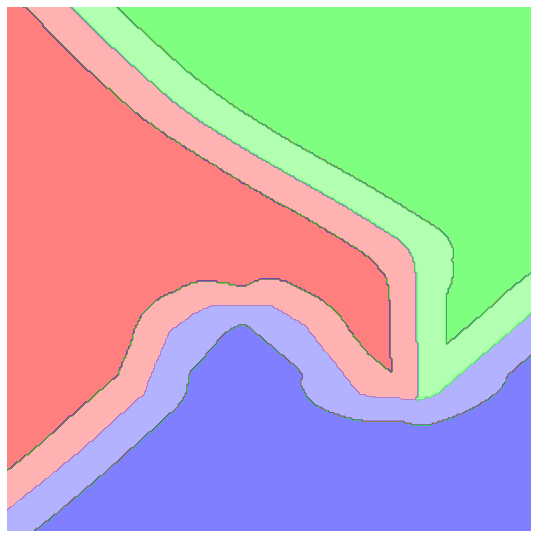

In [89]:
ZZ3_raw, C3 = get_robust_predictions(XX.copy(), YY.copy(), m3)

ZZ3 = torch.where(C3 == True, ZZ3_raw, torch.zeros((N, N)).long()+3)

fig, ax = plt.subplots(figsize=(8,8))

if not use_shaded_color:
    ZZ3 = torch.where(C3 == True, ZZ3_raw, torch.zeros((N, N)).long()+3)
    ax.contourf(XX,YY, ZZ3, colors=[[1, 0, 0, 0.5], 
                                    [0, 0, 1, 0.5], 
                                    [0., 1, 0, 0.5], 
                                    [0., 0, 0, 0.4]], 
                levels=3)
else:
    ZZ3 = color_the_boundary(ZZ3_raw, C3)
    ax.contourf(XX,YY, ZZ3, colors=[[1, 0, 0, 0.5], 
                                    [0, 0, 1, 0.5], 
                                    [0, 1, 0, 0.5], 
                                    [1, 0, 0, 0.3],
                                    [0, 0, 1, 0.3],
                                    [0, 1, 0, 0.3],
                                    [0, 1, 0, 0.3]])


# ax.scatter(X_train_right[y_train==0][:,0], X_train_right[y_train==0][:,1], c=[1, 0, 0, 1.0], s=70, edgecolors='k')
# ax.scatter(X_train_right[y_train==1][:,0], X_train_right[y_train==1][:,1], c=[0, 0, 1, 1.0], s=70, edgecolors='k')
# ax.scatter(X_train_right[y_train==2][:,0], X_train_right[y_train==2][:,1], c=[0, 1, 0, 1.0], s=70, edgecolors='k')
ax.axis("off")
ax.axis([0,1,-0.2,1.2])
plt.tight_layout()
plt.savefig("m3.pdf", dpi=300)
plt.show()

In [90]:
def cascade(y_pred, certified):
    predictions = []
    certificates = []
    for i in range(np.shape(y_pred)[1]):
        certified_yet = False
        for j in range(np.shape(y_pred)[0]-1):
            if certified[j][i] == 1 and not certified_yet:
                predictions.append(y_pred[j][i])
                certificates.append(1)
                certified_yet = True
                
        if not certified_yet:
            predictions.append(y_pred[np.shape(y_pred)[0]-1][i])
            certificates.append(certified[np.shape(y_pred)[0]-1][i])
            
    certificates = np.array(certificates).astype(np.int32)

    return predictions, certificates

In [91]:
y_pred = np.array([ZZ1_raw.flatten().numpy(), ZZ2_raw.flatten().numpy(), ZZ3_raw.flatten().numpy()])
certified = np.array([C1.flatten().numpy(), C2.flatten().numpy(), C3.flatten().numpy()])

In [92]:
cas_ZZ_raw, cas_CC = cascade(y_pred, certified)
cas_ZZ_raw = np.reshape(cas_ZZ_raw, (N, N))
cas_CC = np.reshape(cas_CC, (N, N))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


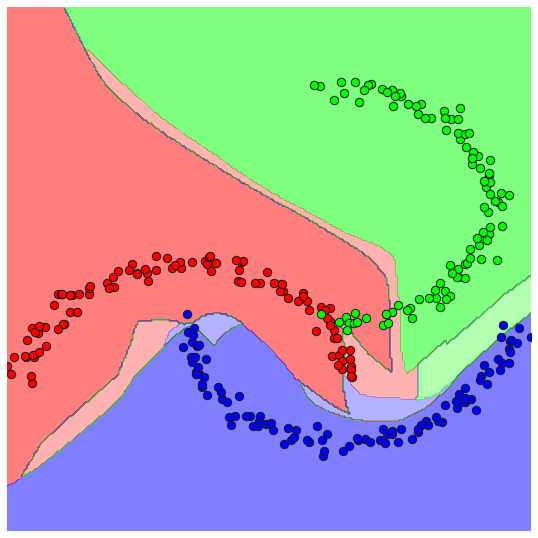

In [93]:
# cas_ZZ = np.where(cas_CC == np.ones_like(cas_CC), cas_ZZ_raw, np.zeros((N, N))+3)

fig, ax = plt.subplots(figsize=(8,8))

# ax.contourf(XX,YY, cas_ZZ, colors=[[1, 0, 0, 0.5], [0, 0, 1, 0.5] , [0., 1, 0, 0.5], [0., 0, 0, 0.4]], levels=3)


if not use_shaded_color:
    cas_ZZ = torch.where(cas_CC == True, cas_ZZ_raw, torch.zeros((N, N)).long()+3)
    ax.contourf(XX,YY, cas_ZZ, colors=[[1, 0, 0, 0.5], 
                                    [0, 0, 1, 0.5], 
                                    [0., 1, 0, 0.5], 
                                    [0., 0, 0, 0.4]], 
                levels=3)
else:
    cas_ZZ = color_the_boundary(cas_ZZ_raw, cas_CC)
    ax.contourf(XX,YY, cas_ZZ, colors=[[1, 0, 0, 0.5], 
                                    [0, 0, 1, 0.5], 
                                    [0, 1, 0, 0.5], 
                                    [1, 0, 0, 0.3],
                                    [0, 0, 1, 0.3],
                                    [0, 1, 0, 0.3],
                                    [0, 1, 0, 0.3]])



ax.scatter(X_train[y_train==0][:,0], X_train[y_train==0][:,1], c=[1, 0, 0, 1], s=70, edgecolors='k')
ax.scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1], c=[0, 0, 1, 1], s=70, edgecolors='k')
ax.scatter(X_train[y_train==2][:,0], X_train[y_train==2][:,1], c=[0, 1, 0, 1], s=70, edgecolors='k')
ax.axis("off")
plt.tight_layout()
plt.savefig("kw_ensemble.pdf", dpi=300)
plt.show()

In [106]:
ens_ZZ, ens_CC, vote_acc, vote_vra, weights = matrix_op_robust_voting(
    y_pred,
    np.ones((N*N,)),
    certified.astype(np.int32),
    solve_for_weights=False,
    num_classes=3,
    weights=np.array([1.0, 0.98, 0.99]))

ens_ZZ = ens_ZZ.reshape((N, N))
ens_CC = ens_CC.reshape((N, N))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


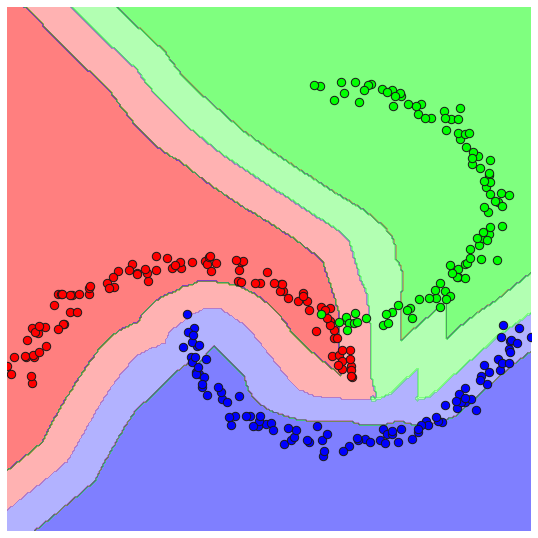

In [107]:

fig, ax = plt.subplots(figsize=(8,8))


if not use_shaded_color:
    ens_ZZ = np.where(ens_CC == np.ones_like(ens_ZZ), ens_ZZ, np.zeros_like(ens_ZZ)+3)
    ax.contourf(XX,YY, ens_ZZ, colors=[[1, 0, 0, 0.5], [0, 0, 1, 0.5] , [0., 1, 0, 0.5], [0., 0, 0, 0.4]], levels=3)


else:
    ens_ZZ = color_the_boundary(ens_ZZ, ens_CC)
    ax.contourf(XX,YY, ens_ZZ, colors=[[1, 0, 0, 0.5], 
                                    [0, 0, 1, 0.5], 
                                    [0, 1, 0, 0.5], 
                                    [1, 0, 0, 0.3],
                                    [0, 0, 1, 0.3],
                                    [0, 1, 0, 0.3],
                                    [0, 1, 0, 0.3]])



ax.scatter(X_train[y_train==0][:,0], X_train[y_train==0][:,1], c=[1, 0, 0, 1.0], s=70, edgecolors='k')
ax.scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1], c=[0, 0, 1, 1.0], s=70, edgecolors='k')
ax.scatter(X_train[y_train==2][:,0], X_train[y_train==2][:,1], c=[0, 1, 0, 1.0], s=70, edgecolors='k')
ax.axis("off")
plt.tight_layout()
plt.savefig("voting_ensemble.pdf", dpi=300)
plt.show()